## Práctica 4. Procesamiento audio

### Ejercicio 1: Construir un identificador de notas musicales. Es decir; en su versión más sencilla (y suficiente) la entrada es un sonido con una sola nota musical y debe identificar cuál es. Por simplicidad elija un único instrumento para la identificación.  

(APORTES ADICIONALES)   
a) El caso más sencillo es el del piano, pero se valorará que se haga con otros instrumentos como la guitarra, la trompeta…    
b) Se valorará que se identifiquen octavas de notas

In [3]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. TABLA DE NOMBRES DE NOTAS (NOTACIÓN INTERNACIONAL)
# ----------------------------------------------------
NOTE_NAMES = ["Do", "Do#", "Re", "Re#", "Mi", "Fa",
              "Fa#", "Sol", "Sol#", "La", "La#", "Si"]

# ----------------------------------------------------
# 2. DETECCIÓN DE FRECUENCIA DOMINANTE CON FFT
# ----------------------------------------------------
def detectar_frecuencia_fft(audio_data, sample_rate,
                            min_freq=20, max_freq=None,
                            plot=False):
    """
    Detecta la frecuencia dominante de un audio usando FFT.

    audio_data : array de muestras
    sample_rate: frecuencia de muestreo (Hz)
    min_freq   : frecuencia mínima a considerar (Hz)
    max_freq   : frecuencia máxima a considerar (Hz, por defecto Nyquist)
    plot       : si True, muestra el espectro de magnitud
    """

    # Si es estéreo, pasamos a mono haciendo la media
    if audio_data.ndim == 2:
        audio_data = audio_data.mean(axis=1)

    # Convertimos a float y quitamos componente DC (media)
    audio = audio_data.astype(np.float32)
    audio = audio - np.mean(audio)

    # Ventana de Hamming para reducir fugas espectrales
    window = np.hamming(len(audio))
    audio_win = audio * window

    # FFT de solo la parte real positiva (rfft)
    N = len(audio_win)
    spectrum = np.fft.rfft(audio_win)
    freqs = np.fft.rfftfreq(N, d=1.0 / sample_rate)
    magnitude = np.abs(spectrum)

    # Limitamos el rango de búsqueda (por ejemplo, 20 Hz – Nyquist o max_freq)
    if max_freq is None:
        max_freq = sample_rate / 2

    valid = (freqs >= min_freq) & (freqs <= max_freq)

    freqs_valid = freqs[valid]
    mag_valid = magnitude[valid]

    # Índice del pico máximo en el rango válido
    idx_peak = np.argmax(mag_valid)
    freq_dominante = freqs_valid[idx_peak]

    # (Opcional) Representación gráfica del espectro
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(freqs_valid, mag_valid)
        plt.axvline(freq_dominante, linestyle="--")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Magnitud")
        plt.title(f"Espectro de magnitud (pico en {freq_dominante:.2f} Hz)")
        plt.grid(True)
        plt.show()

    return freq_dominante

# ----------------------------------------------------
# 3. CONVERTIR FRECUENCIA A NOTA Y OCTAVA
# ----------------------------------------------------
def frecuencia_a_nota(f):
    """
    Convierte una frecuencia (Hz) en nota y octava usando
    afinación estándar A4 = 440 Hz.

    Devuelve:
      nombre_nota (str), octava (int), numero_midi (int)
    """

    if f <= 0:
        return None, None, None

    # Fórmula estándar: A4 (La4) es MIDI 69 y 440 Hz
    midi = int(round(69 + 12 * np.log2(f / 440.0)))

    nombre_nota = NOTE_NAMES[midi % 12]
    octava = midi // 12 - 1  # Definición usual de octava
    return nombre_nota, octava, midi


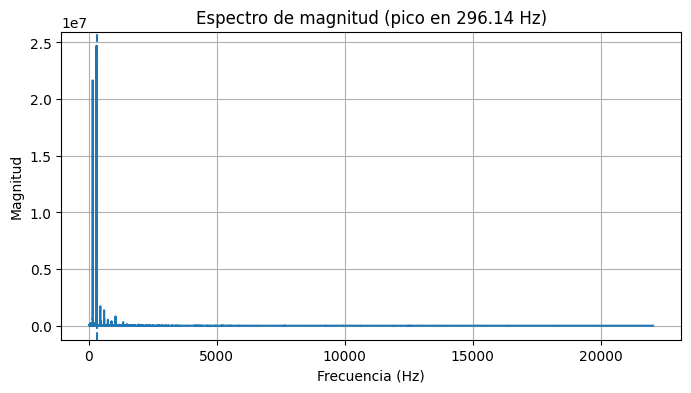

Frecuencia detectada: 296.14 Hz
Nota identificada: Re4 (MIDI 62)


In [12]:
# ----------------------------------------------------
# 4. EJEMPLO COMPLETO: LEER WAV, DETECTAR NOTA
# ----------------------------------------------------
ruta_wav = "Notas/Guitarra/guitar_re.wav"   # o trompeta, guitarra, etc.

sample_rate, audio_data = wavfile.read(ruta_wav)

freq = detectar_frecuencia_fft(audio_data, sample_rate, plot=True)
nota, octava, midi = frecuencia_a_nota(freq)

print(f"Frecuencia detectada: {freq:.2f} Hz")
print(f"Nota identificada: {nota}{octava} (MIDI {midi})")

c) Identificación de acordes (complejo pero espectacular)

In [14]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import find_peaks

# Tabla de notas (frecuencias en la 4ª octava)
NOTAS_ESP = {
    "Do": 261.63, "Do#": 277.18, "Re": 293.66, "Re#": 311.13,
    "Mi": 329.63, "Fa": 349.23, "Fa#": 369.99, "Sol": 392.00,
    "Sol#": 415.30, "La": 440.00, "La#": 466.16, "Si": 493.88
}

# Genera todas las octavas (0–8)
def generar_tabla_notas():
    tabla = {}
    for nota, f_base in NOTAS_ESP.items():
        for octava in range(0, 8):
            f = f_base * (2 ** (octava - 4))
            tabla[f"{nota}{octava}"] = f
    return tabla

TABLA_NOTAS = generar_tabla_notas()


def detectar_acorde_fft(ruta_wav, n_top=5, plot=False):
    sr, audio = wavfile.read(ruta_wav)
    if audio.ndim == 2:
        audio = audio.mean(axis=1)

    audio = audio.astype(float)
    audio -= np.mean(audio)

    window = np.hamming(len(audio))
    audio *= window

    N = len(audio)
    spectrum = np.fft.rfft(audio)
    freqs = np.fft.rfftfreq(N, 1/sr)
    mag = np.abs(spectrum)

    # Encontrar picos importantes
    peaks, _ = find_peaks(mag, height=np.max(mag)*0.1)
    freqs_picos = freqs[peaks]

    # Elegimos los n_top picos más fuertes
    picos_importantes = freqs_picos[:n_top]

    notas_detectadas = []

    for f in picos_importantes:
        # Buscar nota más cercana en las tablas
        nota_cercana = min(TABLA_NOTAS.keys(),
                           key=lambda n: abs(TABLA_NOTAS[n] - f))
        notas_detectadas.append(nota_cercana)

    return sorted(set(notas_detectadas))


# Ejemplo:
acorde = detectar_acorde_fft("acorde_CEG_A.wav")
print("Notas detectadas:", acorde)


Notas detectadas: ['Do4', 'La4', 'Mi4', 'Sol4']
